In [1]:
#Import useful modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import random
from keras import models
from keras import layers
from keras import regularizers
from sklearn import ensemble

Using TensorFlow backend.


In [78]:
#Set directory and import the Letters data
os.chdir('D:\MSc2\Deep Learning Keras\Task3')
data = pd.read_csv('Concrete_Data.csv', header = 0)

#Randomly shuffle the data
data = data.iloc[np.random.permutation(data.shape[0]),].reset_index(drop=True)

In [140]:
#data.head() #Last column is the target (continuous)
#data.shape #(1030, 9)
#data.describe() #need to normalize
#data.info() #all float64/int64
#data.columns.values #column names

In [79]:
##Section 1: Data cleaning and Exploratory Data Analysis
#Rename the columns 
data.columns = ["Feature" + str(num1) for num1 in range(1,9)] + ['Response']

#Create features and labels
y = data['Response'] #continuous - pandas series (type categoy)
x = data.iloc[:,0:8] #features all continuous

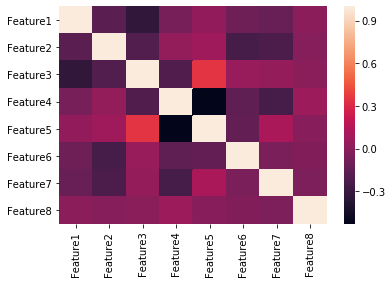

In [142]:
#Check correlation between features using a heat map
#pearson
#sns.heatmap(x.corr(method = 'pearson')) 

#kendall
sns.heatmap(x.corr(method = 'kendall'))

#not much correlated

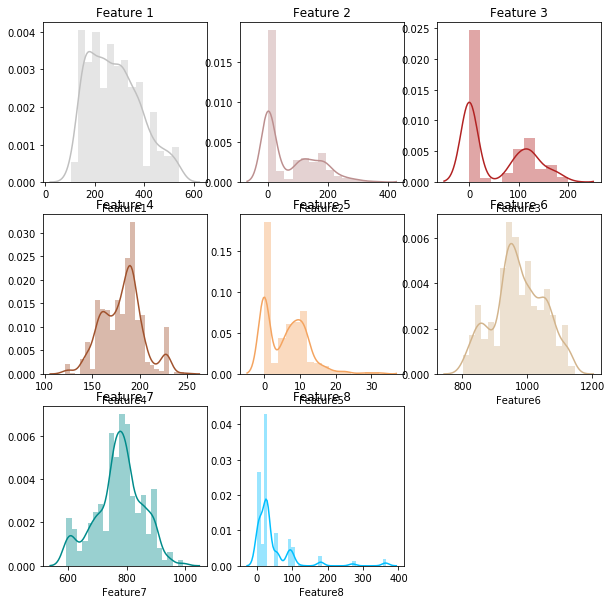

In [143]:
#check distribution of the features
#Plot all 16 Feature distribution
platte = ["silver","rosybrown","firebrick","sienna","sandybrown","tan","darkcyan","deepskyblue"]
f = plt.figure(figsize=(10,10))
for i in range(0,8): 
    plt.subplot(3, 3, i+1)
    #plt.hist(x.iloc[:,i],normed=True,bins=15,color=platte[i-1])
    sns.distplot(x.iloc[:,i],color=platte[i])
    plt.title('Feature ' + str(i+1))

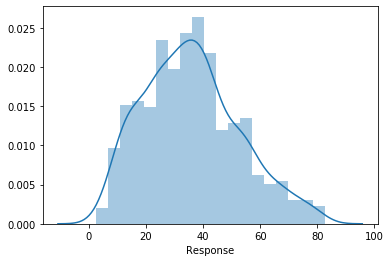

In [144]:
#check distribution of the response (continuous) - looks normal
sns.distplot(y)

In [80]:
##Section 2. Prepare data for modelling
n = data.shape[0]
k = 0.9
q = int(round(n*k))

#First convert to numpy arrays and perform the train-test split (70%-30%)
x = np.asarray(x).astype('float64')
y = np.asarray(y).astype('float64')

train_x = x[:q,:] 
test_x = x[q:,:] 
train_y = y[:q]
test_y = y[q:]

#Then standardize features and convert to numpy arrays
mean = train_x.mean(axis = 0)
std = train_x.std(axis = 0)

train_x = (train_x - mean)/std #scale the training data
test_x = (test_x - mean)/std #Note: scale the test data using quantities from the training data 
                              #to prevent information flow into the future (test data = future/unseen data)

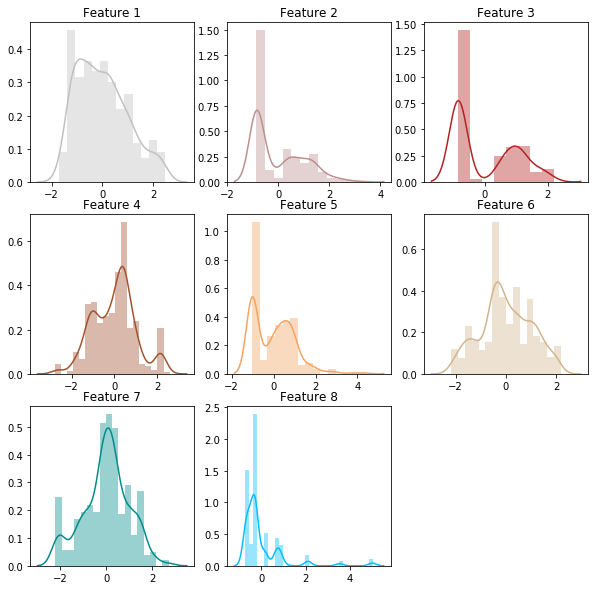

In [146]:
#type(train_x), type(train_y), type(test_x), type(test_y) #(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
#train_x.shape, train_y.shape, test_x.shape, test_y.shape #((721, 8), (721,), (309, 8), (309,))
#verify the scaled data
#check distribution of the features
#Plot all 16 Feature distribution
platte = ["silver","rosybrown","firebrick","sienna","sandybrown","tan","darkcyan","deepskyblue"]
f = plt.figure(figsize=(10,10))
for i in range(0,8): 
    plt.subplot(3, 3, i+1)
    #plt.hist(x.iloc[:,i],normed=True,bins=15,color=platte[i-1])
    sns.distplot(train_x[:,i],color=platte[i])
    plt.title('Feature ' + str(i+1))

In [81]:
##Section 3. Model Building
#1)Architecture of the model
def model_build():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(train_x.shape[1],)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1)) #no activation - linear layer
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #Optimizer, Loss function, Metrics
    
    return model

In [54]:
#2)Train the model 
n = 30000 # number of epochs
q = int(0.3*train_x.shape[0]) #70%-30% train vs dev 
x_val = train_x[:q] #train vs dev sets
partial_x_train = train_x[q:]
y_val = train_y[:q]
partial_y_train = train_y[q:]

model = model_build()
history = model.fit(partial_x_train,partial_y_train,epochs=n,batch_size=512,validation_data=(x_val,y_val),
                   verbose=0) 
history_dict = history.history

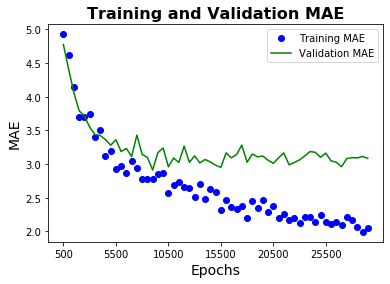

(1.993702400814403, 2.9135420322418213)

In [58]:
#3)Tuning - Plot loss and accuracy (training vs dev) - Overfitting after epoch = 150
epochs = range(500,n,500)
mae = [history_dict['mean_absolute_error'][i] for i in epochs]
val_mae = [history_dict['val_mean_absolute_error'][i] for i in epochs]
plt.plot(epochs,mae, 'bo', label='Training MAE')
plt.plot(epochs,val_mae, 'g-', label='Validation MAE')
plt.xticks(range(500,n+1,5000))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

np.min(mae),np.min(val_mae)

In [ ]:
#4)Finalize - retraining the model using whole training set
model = model_build()
model.fit(train_x, train_y, epochs=25000,batch_size=512,verbose=0)

In [ ]:
#5)Evaluate on the test set - MAE
model.evaluate(test_x,test_y)[1] #MAE = 2.6003090143203735

(array([ 1.,  0.,  0.,  5., 14., 56., 20.,  5.,  0.,  2.]),
 array([-10.69293671,  -8.67687148,  -6.66080624,  -4.64474101,
         -2.62867578,  -0.61261055,   1.40345468,   3.41951991,
          5.43558514,   7.45165038,   9.46771561]),
 <a list of 10 Patch objects>)

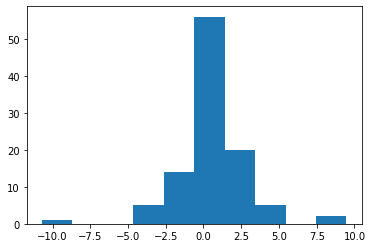

In [84]:
#6)Closer look at the test set performance
predictions = model.predict(test_x, verbose=0) #see the soft probability of the predicted data
predictions = predictions.reshape((predictions.shape[0],))
plt.hist(predictions - test_y) #error distribution - looks normal

In [ ]:
#Baseline model 1 (guess the mean)
predictions = np.mean(test_y)
MAE = np.mean(np.abs(predictions - test_y))
MAE #12.426605712131211

In [ ]:
#Baseline model 2(Gradient boosting)
params = {'n_estimators': 3500,'learning_rate':0.05}
model_tree = ensemble.GradientBoostingRegressor(**params)
model_tree.fit(train_x,train_y)
predictions = model_tree.predict(test_x)
MAE = np.mean(np.abs(predictions - test_y))
MAE #2.865245098216485

